In [ ]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/data
!unzip \*.zip  && rm *.zip

In [ ]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/cars_data_brands_only/car_data/train',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/cars_data_brands_only/car_data/train',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/cars_data_brands_only/car_data/test',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 6535 images belonging to 49 classes.
Found 1609 images belonging to 49 classes.
Found 8041 images belonging to 49 classes.


In [ ]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=49):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [ ]:
model = build_vgg16_transfer_learning_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 1,229,361
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_name = "vgg16_cars_49_classes.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
205/205 [==============================] - 138s 654ms/step - loss: 3.5252 - accuracy: 0.1051 - val_loss: 3.1568 - val_accuracy: 0.1622
Epoch 2/100
205/205 [==============================] - 132s 647ms/step - loss: 3.0036 - accuracy: 0.1906 - val_loss: 3.0062 - val_accuracy: 0.2063
Epoch 3/100
205/205 [==============================] - 133s 650ms/step - loss: 2.7585 - accuracy: 0.2601 - val_loss: 2.7888 - val_accuracy: 0.2492
Epoch 4/100
205/205 [==============================] - 132s 645ms/step - loss: 2.5561 - accuracy: 0.3057 - val_loss: 2.6980 - val_accuracy: 0.2691
Epoch 5/100
205/205 [==============================] - 132s 644ms/step - loss: 2.3801 - accuracy: 0.3525 - val_loss: 2.6319 - val_accuracy: 0.2884
Epoch 6/100
205/205 [==============================] - 133s 649ms/step - loss: 2.3153 - accuracy: 0.3764 - val_loss: 2.5921 - val_accuracy: 0.2958
Epoch 7/100
205/205 [==============================] - 132s 646ms/step - loss: 2.2358 - accuracy: 0.3945 - val_loss: 2

In [ ]:
## finetune model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(224,224,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(49,activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 15,944,049
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch = 128
num_epochs = 100
history_2 = model.fit(train_generator,
          validation_data = val_generator,
          epochs=num_epochs,
          verbose=1,
          batch_size=batch,
          callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
205/205 [==============================] - 133s 642ms/step - loss: 1.7347 - accuracy: 0.5120 - val_loss: 2.2188 - val_accuracy: 0.3773
Epoch 2/100
205/205 [==============================] - 132s 642ms/step - loss: 1.5352 - accuracy: 0.5512 - val_loss: 2.2280 - val_accuracy: 0.3860
Epoch 3/100
205/205 [==============================] - 131s 639ms/step - loss: 1.4562 - accuracy: 0.5682 - val_loss: 2.1725 - val_accuracy: 0.4114
Epoch 4/100
205/205 [==============================] - 132s 645ms/step - loss: 1.4368 - accuracy: 0.5815 - val_loss: 2.1277 - val_accuracy: 0.4239
Epoch 5/100
205/205 [==============================] - 132s 641ms/step - loss: 1.3596 - accuracy: 0.6011 - val_loss: 2.1422 - val_accuracy: 0.4027
Epoch 6/100
205/205 [==============================] - 131s 640ms/step - loss: 1.3039 - accuracy: 0.6117 - val_loss: 2.1099 - val_accuracy: 0.4195
Epoch 7/100
205/205 [==============================] - 132s 642ms/step - loss: 1.3014 - accuracy: 0.6126 - val_loss: 2

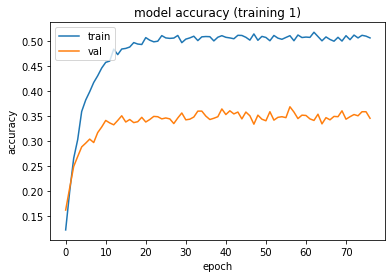

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/gdrive/MyDrive/Kaggle/data/vgg16_cars_49_classes.h5')
metrics = model.evaluate(test_generator)

252/252 [==============================] - 68s 271ms/step - loss: 1.9522 - accuracy: 0.4817


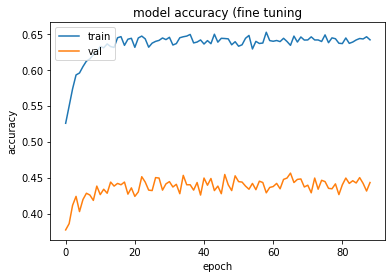

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy (fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

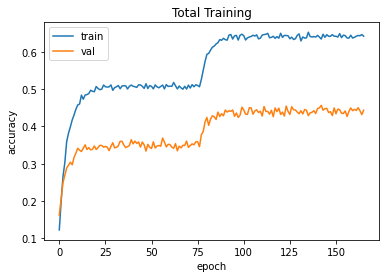

In [ ]:
acc_total = np.zeros(len(history.history['accuracy']) + len(history_2.history['accuracy']))
val_total = np.zeros(len(history.history['val_accuracy']) + len(history_2.history['val_accuracy']))

for i in range(len(history.history['accuracy'])):
  acc_total[i] = history.history['accuracy'][i]
  val_total[i] = history.history['val_accuracy'][i]
  
for j in range(len(history_2.history['accuracy'])):
  acc_total[j+len(history.history['accuracy'])] = history_2.history['accuracy'][j]
  val_total[j+len(history.history['val_accuracy'])] = history_2.history['val_accuracy'][j]



plt.plot(acc_total)
plt.plot(val_total)
plt.title('Total Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

In [ ]:
max(history_2.history['val_accuracy'])

0.4561839699745178

In [ ]:
max(history_2.history['accuracy'])

0.6520275473594666